## Lane Shape Modeling
1) load the trained Instance Segmentation model
2) predict lane masks
3) fit mathematical equations (Polynomials/Splines) to the detected lanes.

In [1]:
import os
import json
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt


# Configuration
BASE_DIR = os.getcwd()
DATA_DIR = r'C:\Users\Alex\Documents\Clase\Italia\Segundo_ano\ADAS\Project\TU_Simple_folder\TUSimple'
TRAIN_SET_DIR = os.path.join(DATA_DIR, 'train_set')
PROCESSED_DATA_DIR = os.path.join(DATA_DIR, r'processed\instance')
CHECKPOINT_DIR = os.path.join(BASE_DIR, r'checkpoints\instance')
eval_filename = f'best_model_instance_e20.pth'
EVAL_MODEL_PATH = os.path.join(CHECKPOINT_DIR, eval_filename)
# Polynomial degree to fit
polynomial_degree = 2 

NUM_CLASSES = 6 
IMG_HEIGHT = 288
IMG_WIDTH = 512
EPOCHS = 5 
BATCH_SIZE = 8
LEARNING_RATE = 5*1e-4
model_filename = f'best_model_instance_e{EPOCHS}.pth'
BEST_MODEL_PATH = os.path.join(CHECKPOINT_DIR, model_filename)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Model & Dataset Definitions
Same as lane detection

In [2]:
class TuSimpleDataset(Dataset):
    def __init__(self, root_dir, processed_dir, json_files, transform=None):
        self.root_dir = root_dir
        self.processed_dir = processed_dir
        self.transform = transform
        self.samples = []

        for json_file in json_files:
            json_path = os.path.join(root_dir, json_file)
            if not os.path.exists(json_path):
                continue
                
            with open(json_path, 'r') as f:
                lines = f.readlines()
            
            for line in lines:
                info = json.loads(line)
                raw_file = info['raw_file']
                mask_file = raw_file.replace('.jpg', '.png')
                img_path = os.path.join(self.root_dir, raw_file)
                mask_path = os.path.join(self.processed_dir, mask_file)
                self.samples.append((raw_file, mask_file))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_rel_path, mask_rel_path = self.samples[idx]
        img_path = os.path.join(self.root_dir, img_rel_path)
        mask_path = os.path.join(self.processed_dir, mask_rel_path)
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)

        image = image.astype(np.float32) / 255.0
        image = np.transpose(image, (2, 0, 1))
        image = torch.from_numpy(image).float()
        mask = torch.from_numpy(mask).long()
        return image, mask

In [3]:
# U-Net Architecture
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        out = self.outc(x)
        return out

## 3. Execution & Visualization

In [7]:
def evaluate_shapes(model_path, data_dir, processed_dir, json_files, polydegree):
    # Number of random samples to visualize (this function is for qualitative inspection)
    num_visualize = 20
    dataset = TuSimpleDataset(data_dir, processed_dir, json_files)
    loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)
    
    model = UNet(n_channels=3, n_classes=NUM_CLASSES).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))

    model.eval()
    
    # Colors for visualization (up to 5 lanes)
    colors = [
        (0, 0, 0),       # Background
        (0, 255, 0),     # Lane 1
        (255, 0, 0),     # Lane 2
        (0, 0, 255),     # Lane 3
        (255, 255, 0),   # Lane 4
        (255, 0, 255)    # Lane 5
    ]
    
    count = 0
    
    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Fitting Shapes"):
            if count >= num_visualize: break
            
            images = images.to(device)
            
            output = model(images)
            probs = torch.softmax(output, dim=1)
            pred_mask = torch.argmax(probs, dim=1).cpu().numpy()[0]
            
            # Convert image tensor back to uint8 image for OpenCV drawing
            img_np = images[0].cpu().permute(1, 2, 0).numpy()
            img_np = (img_np * 255).astype(np.uint8)
            img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
            
            viz_img = img_np.copy()
            
            # Fitting logic
            height, width = pred_mask.shape
            plot_y = np.linspace(0, height-1, height)
            
             # Fit a curve independently for each lane class (1..5)
            for cls_idx in range(1, NUM_CLASSES):
                # Binary mask for current lane class
                lane_mask = (pred_mask == cls_idx).astype(np.uint8)
                
                # Blob filtering
                # Keep only the largest blob if it is "lane-like" (large enough and tall enough)
                lane_mask_uint8 = lane_mask.astype(np.uint8)
                num_labels, labels_im, stats, centroids = cv2.connectedComponentsWithStats(lane_mask_uint8, connectivity=8)
                valid_lane = False
                if num_labels > 1:

                    # Find component with maximum area 
                    largest_idx = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1
                    max_area = stats[largest_idx, cv2.CC_STAT_AREA]
                    max_height = stats[largest_idx, cv2.CC_STAT_HEIGHT]
                    
                    # Thresholds to reject small or short components
                    if max_area >= 1000 and max_height >= 50:
                        lane_mask = (labels_im == largest_idx).astype(np.uint8)
                        valid_lane = True
                
                if valid_lane:
                    # Extract lane pixels as x, y coordinates
                    y_coords, x_coords = np.where(lane_mask == 1)
                    
                    # Fit Polynomial
                    lane_fit = np.polyfit(y_coords, x_coords, polydegree) 
                    print(f'Lane {cls_idx} Equation: x = {lane_fit[0]:.6f}*y^2 + {lane_fit[1]:.6f}*y + {lane_fit[2]:.6f}')
                    
                    # Plot only where lane pixels exist
                    plot_y_min = np.min(y_coords)
                    plot_y_max = np.max(y_coords)
                    plot_y_constrained = np.linspace(plot_y_min, plot_y_max, int(plot_y_max - plot_y_min + 1))
                    
                    lane_fitx = np.polyval(lane_fit, plot_y_constrained)
                    
                    # Draw Points
                    pts = np.array([np.transpose(np.vstack([lane_fitx, plot_y_constrained]))])
                    pts = pts.astype(np.int32)
                    
                    color_rgb = colors[cls_idx if cls_idx < len(colors) else 1]
                    color_bgr = (color_rgb[2], color_rgb[1], color_rgb[0])
                    
                    cv2.polylines(viz_img, pts, isClosed=False, color=color_bgr, thickness=2) # THICKNESS 2

            
            # Plot
            plt.figure(figsize=(10, 5))
            plt.title("Lane Shape Modeling (Polynomial Fit)")
            plt.imshow(cv2.cvtColor(viz_img, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()
            
            count += 1


Fitting Shapes:   0%|          | 0/3626 [00:00<?, ?it/s]

Lane 1 Equation: x = 0.000931*y^2 + -1.605885*y + 424.621226
Lane 2 Equation: x = 0.000397*y^2 + 0.814291*y + 189.712385
Lane 3 Equation: x = 0.005944*y^2 + -4.952894*y + 700.926055
Lane 4 Equation: x = 0.001505*y^2 + 2.736062*y + 1.784786


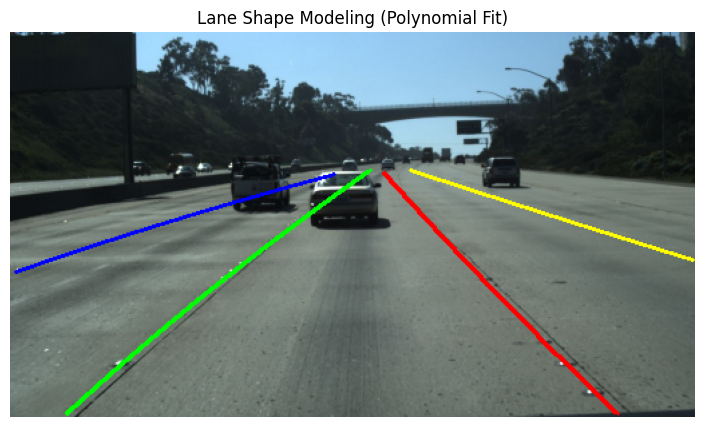

Fitting Shapes:   0%|          | 1/3626 [00:01<1:01:25,  1.02s/it]

Lane 1 Equation: x = 0.002035*y^2 + -1.913793*y + 457.557691
Lane 2 Equation: x = 0.002618*y^2 + 0.001039*y + 276.166705
Lane 3 Equation: x = 0.010674*y^2 + -6.484277*y + 828.012508
Lane 4 Equation: x = 0.016814*y^2 + -1.493108*y + 312.506519


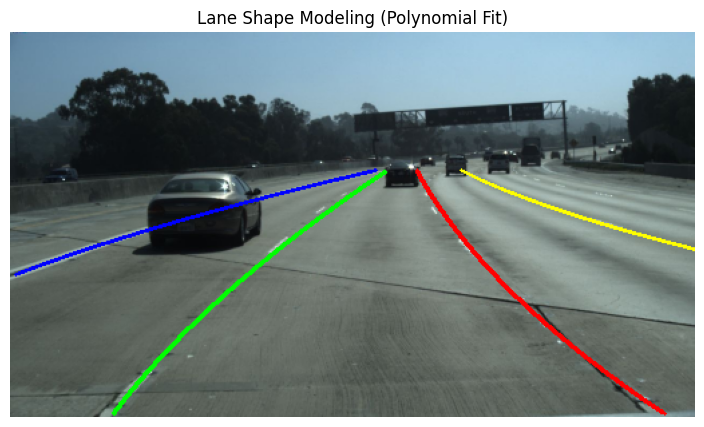

Fitting Shapes:   0%|          | 2/3626 [00:01<32:34,  1.85it/s]  

Lane 1 Equation: x = 0.002867*y^2 + -2.698810*y + 570.330420


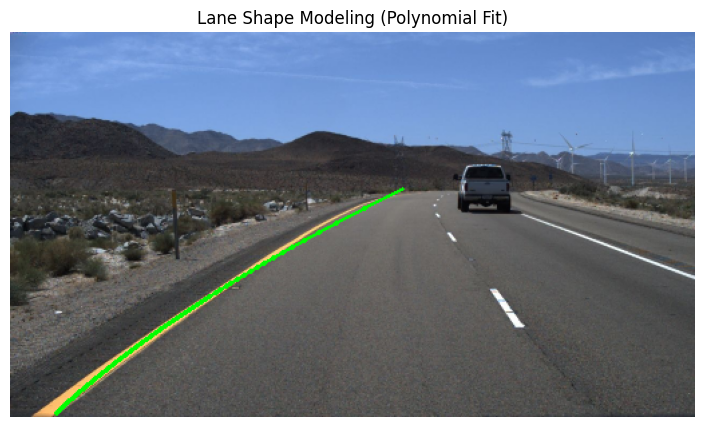

Fitting Shapes:   0%|          | 3/3626 [00:01<23:30,  2.57it/s]

Lane 1 Equation: x = -0.000039*y^2 + -1.006762*y + 354.114143
Lane 2 Equation: x = -0.000588*y^2 + 1.350656*y + 139.793918
Lane 3 Equation: x = 0.002047*y^2 + -3.579560*y + 574.545931
Lane 4 Equation: x = 0.002501*y^2 + 2.724300*y + -6.294285


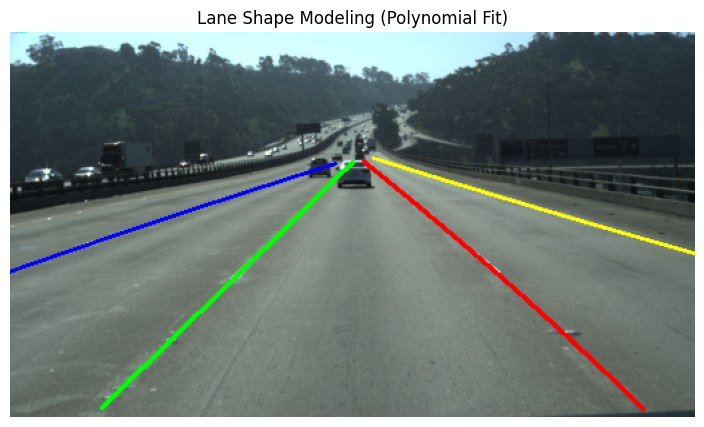

Fitting Shapes:   0%|          | 4/3626 [00:01<19:17,  3.13it/s]

Lane 1 Equation: x = 0.000128*y^2 + -1.055469*y + 361.016862
Lane 2 Equation: x = 0.000208*y^2 + 1.134636*y + 153.142469
Lane 3 Equation: x = -0.000179*y^2 + -3.012987*y + 550.305539
Lane 4 Equation: x = 0.000931*y^2 + 3.275231*y + -53.757442


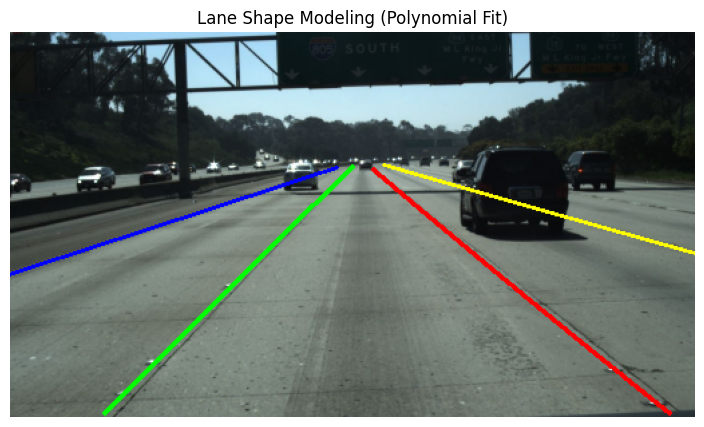

Fitting Shapes:   0%|          | 5/3626 [00:01<16:51,  3.58it/s]

Lane 1 Equation: x = 0.000069*y^2 + -0.844381*y + 327.372917
Lane 2 Equation: x = 0.000148*y^2 + 1.348114*y + 120.855841
Lane 3 Equation: x = -0.006094*y^2 + 5.335895*y + -200.309111


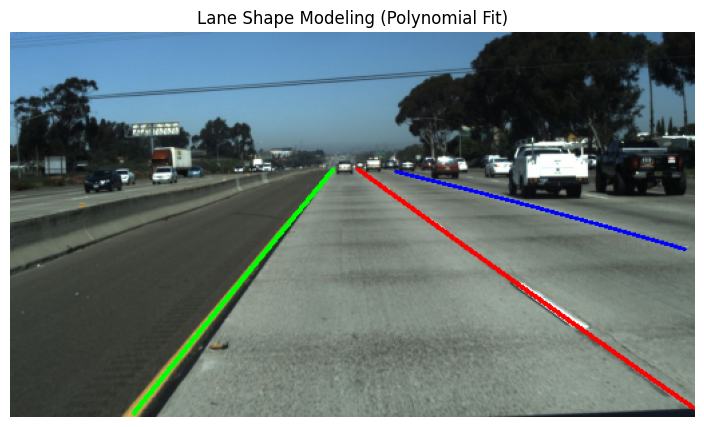

Fitting Shapes:   0%|          | 6/3626 [00:02<15:47,  3.82it/s]

Lane 2 Equation: x = 0.004702*y^2 + -4.674849*y + 681.632926
Lane 3 Equation: x = -0.000240*y^2 + -0.984314*y + 359.039381
Lane 4 Equation: x = 0.000024*y^2 + 1.159525*y + 148.256604


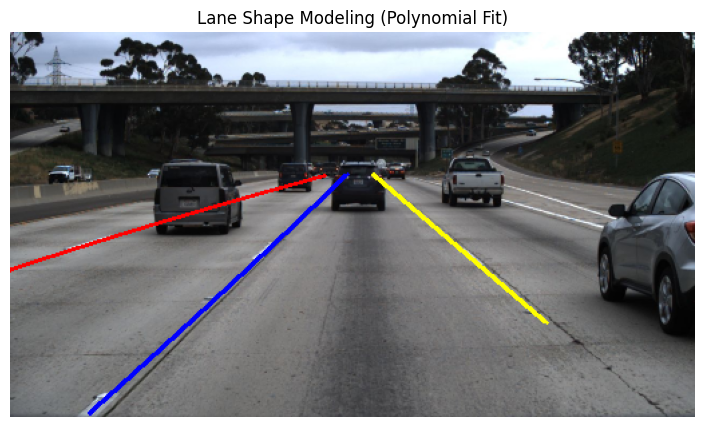

Fitting Shapes:   0%|          | 7/3626 [00:02<14:44,  4.09it/s]

Lane 1 Equation: x = -0.000085*y^2 + -1.147643*y + 361.279167
Lane 2 Equation: x = 0.000171*y^2 + 0.972716*y + 164.472551
Lane 3 Equation: x = 0.000473*y^2 + -3.302942*y + 559.014097
Lane 4 Equation: x = 0.001627*y^2 + 2.771280*y + -10.642946


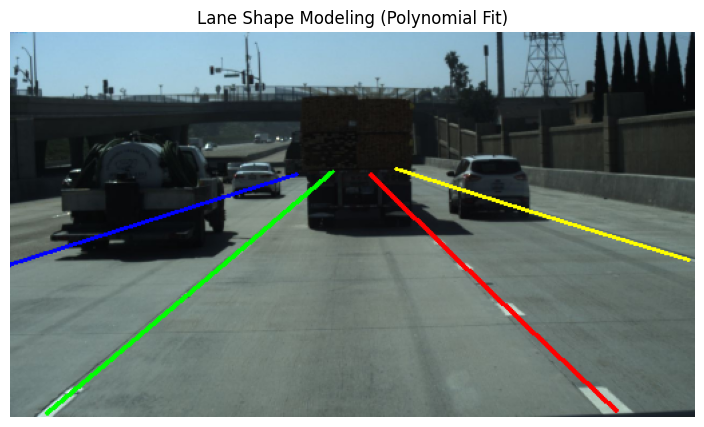

Fitting Shapes:   0%|          | 8/3626 [00:02<14:03,  4.29it/s]

Lane 1 Equation: x = 0.000397*y^2 + -1.096417*y + 363.301420
Lane 2 Equation: x = 0.000045*y^2 + 1.219506*y + 160.384532
Lane 3 Equation: x = 0.002769*y^2 + -3.796833*y + 591.226016
Lane 4 Equation: x = -0.002430*y^2 + 4.248505*y + -102.680138


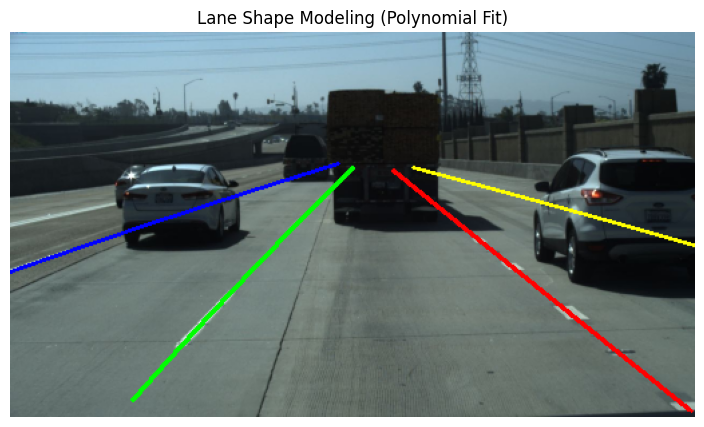

Fitting Shapes:   0%|          | 9/3626 [00:02<13:28,  4.47it/s]

Lane 1 Equation: x = -0.000131*y^2 + -0.847399*y + 341.469105
Lane 2 Equation: x = -0.000091*y^2 + 1.329798*y + 137.055211


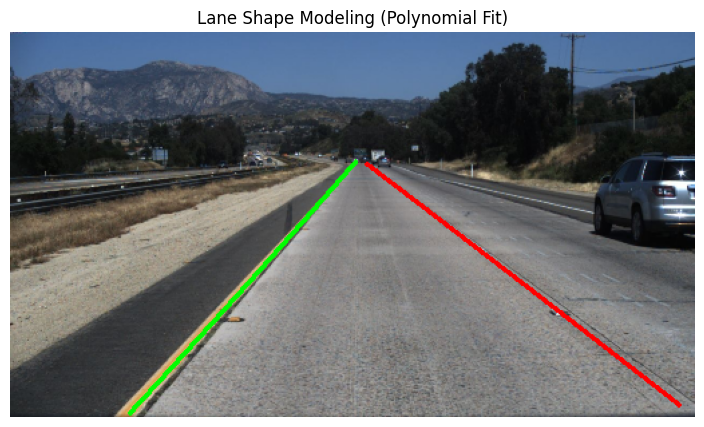

Fitting Shapes:   0%|          | 10/3626 [00:02<13:08,  4.59it/s]

Lane 1 Equation: x = 0.001536*y^2 + -2.168513*y + 509.040680
Lane 2 Equation: x = 0.001930*y^2 + -0.094795*y + 307.944497
Lane 3 Equation: x = 0.009213*y^2 + -6.487284*y + 863.985937
Lane 4 Equation: x = 0.008756*y^2 + 0.038077*y + 248.518339


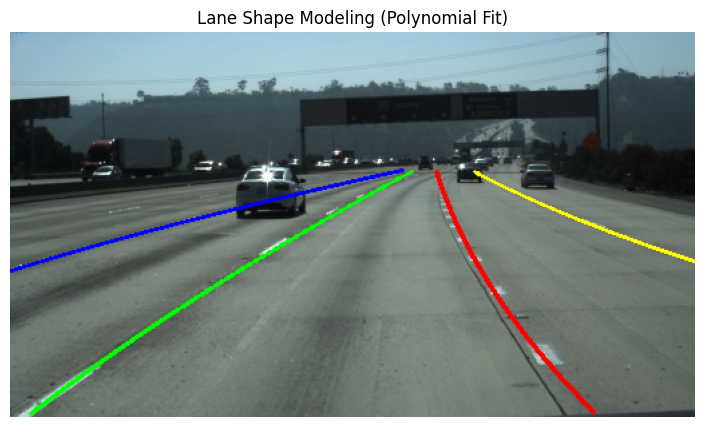

Fitting Shapes:   0%|          | 11/3626 [00:03<13:08,  4.59it/s]

Lane 1 Equation: x = -0.000177*y^2 + -0.868639*y + 338.401212
Lane 2 Equation: x = -0.000699*y^2 + 1.549282*y + 108.380763
Lane 3 Equation: x = 0.001956*y^2 + -3.521003*y + 579.310997
Lane 4 Equation: x = -0.010555*y^2 + 6.785395*y + -325.157179


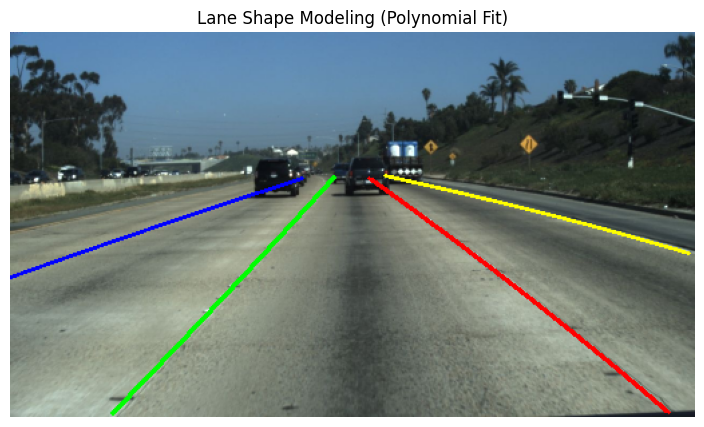

Fitting Shapes:   0%|          | 12/3626 [00:03<13:00,  4.63it/s]

Lane 1 Equation: x = 0.000164*y^2 + -1.160925*y + 384.063880
Lane 2 Equation: x = 0.000692*y^2 + 0.898920*y + 178.174181
Lane 3 Equation: x = -0.000618*y^2 + -2.837991*y + 550.343291
Lane 4 Equation: x = 0.001749*y^2 + 2.785450*y + -9.743887


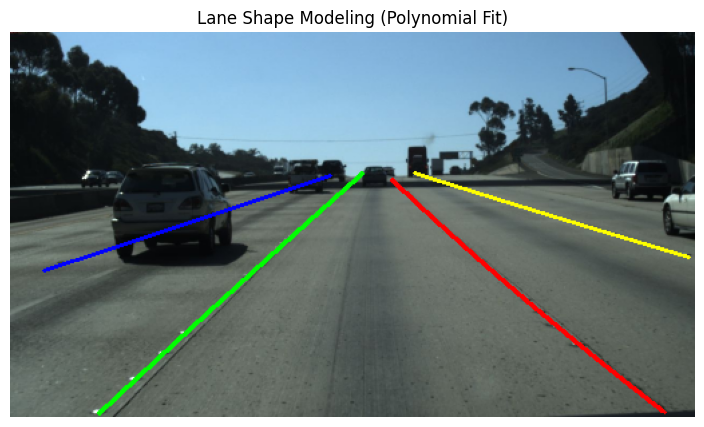

Fitting Shapes:   0%|          | 13/3626 [00:03<12:49,  4.70it/s]

Lane 1 Equation: x = -0.000215*y^2 + -1.030386*y + 344.687331
Lane 2 Equation: x = -0.000179*y^2 + 1.276820*y + 125.583659
Lane 3 Equation: x = 0.000093*y^2 + -3.053657*y + 533.890419
Lane 4 Equation: x = -0.000449*y^2 + 3.475580*y + -79.350634


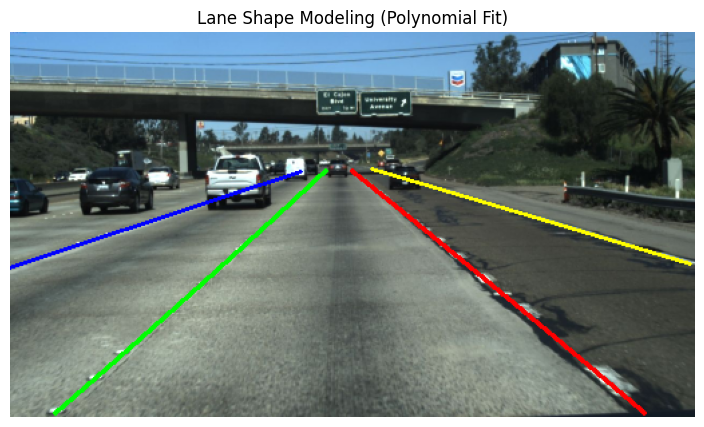

Fitting Shapes:   0%|          | 14/3626 [00:03<12:55,  4.66it/s]

Lane 1 Equation: x = 0.002425*y^2 + -2.052667*y + 460.122091
Lane 2 Equation: x = 0.001920*y^2 + 0.423316*y + 208.239055
Lane 3 Equation: x = 0.012641*y^2 + -7.159602*y + 877.743040
Lane 4 Equation: x = 0.014918*y^2 + -1.509076*y + 294.834379


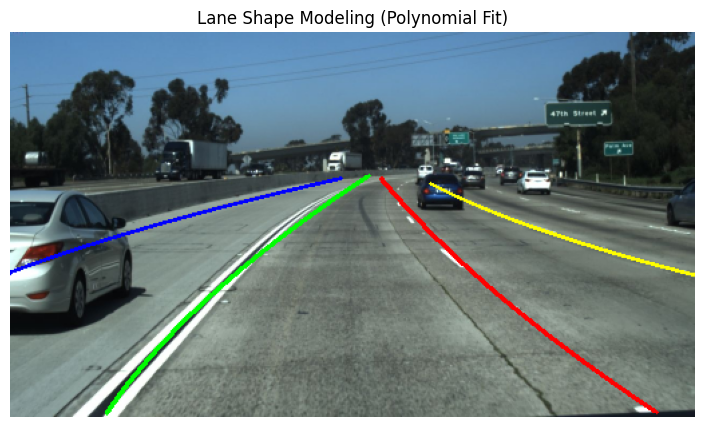

Fitting Shapes:   0%|          | 15/3626 [00:03<12:59,  4.63it/s]

Lane 1 Equation: x = -0.000232*y^2 + -0.840573*y + 342.697797
Lane 2 Equation: x = 0.000008*y^2 + 1.283521*y + 135.691792
Lane 3 Equation: x = 0.000717*y^2 + -2.973401*y + 541.112552
Lane 4 Equation: x = -0.001328*y^2 + 3.693144*y + -87.415269


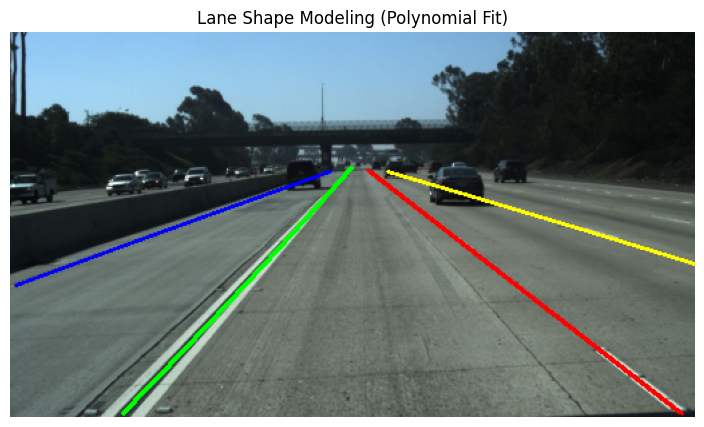

Fitting Shapes:   0%|          | 16/3626 [00:04<13:00,  4.63it/s]

Lane 1 Equation: x = -0.000029*y^2 + -0.890508*y + 344.248207
Lane 2 Equation: x = -0.000276*y^2 + 1.349827*y + 135.378272
Lane 3 Equation: x = -0.000025*y^2 + -2.743492*y + 516.551086
Lane 4 Equation: x = 0.001804*y^2 + 2.723295*y + -5.163527


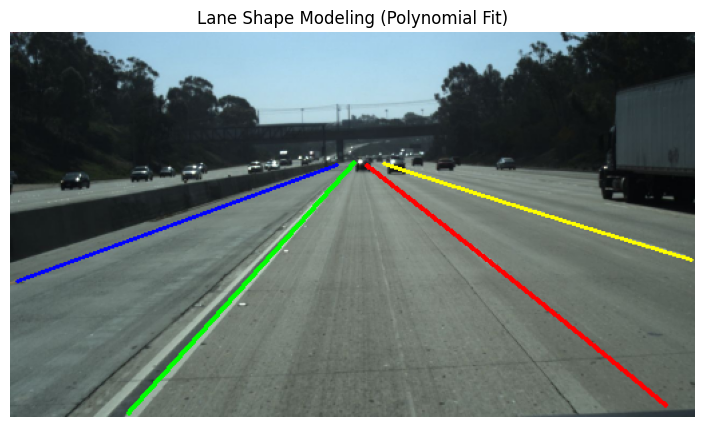

Fitting Shapes:   0%|          | 17/3626 [00:04<13:26,  4.47it/s]

Lane 1 Equation: x = -0.000500*y^2 + -1.212076*y + 380.459864
Lane 2 Equation: x = -0.000493*y^2 + 0.936070*y + 173.924756
Lane 3 Equation: x = -0.003830*y^2 + -2.099684*y + 483.186773
Lane 4 Equation: x = 0.002152*y^2 + 2.320372*y + 20.959560


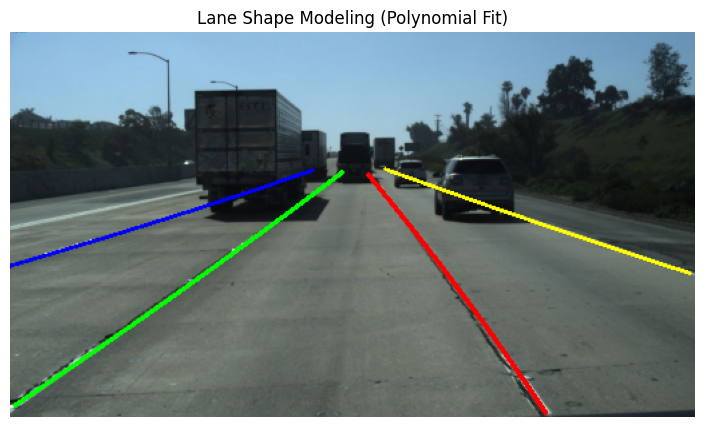

Fitting Shapes:   0%|          | 18/3626 [00:04<13:08,  4.58it/s]

Lane 1 Equation: x = 0.002204*y^2 + -2.042230*y + 475.838738
Lane 2 Equation: x = 0.001826*y^2 + 0.330287*y + 250.959468
Lane 3 Equation: x = 0.008383*y^2 + 0.558119*y + 192.343827


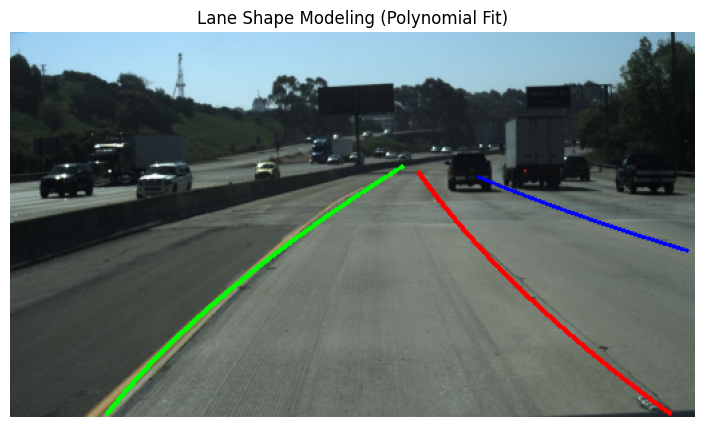

Fitting Shapes:   1%|          | 19/3626 [00:04<13:12,  4.55it/s]

Lane 1 Equation: x = -0.000137*y^2 + -0.882921*y + 348.975229
Lane 2 Equation: x = 0.000165*y^2 + 1.212352*y + 148.516074
Lane 3 Equation: x = 0.001579*y^2 + -3.224396*y + 559.580686
Lane 4 Equation: x = -0.003246*y^2 + 4.036617*y + -88.880908


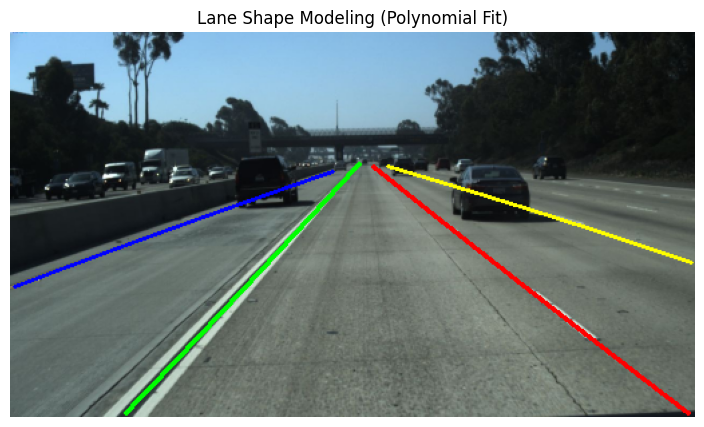

Fitting Shapes:   1%|          | 20/3626 [00:05<15:21,  3.91it/s]


In [8]:

# Run
json_files = ['label_data_0313.json', 'label_data_0531.json', 'label_data_0601.json']
evaluate_shapes(EVAL_MODEL_PATH, TRAIN_SET_DIR, PROCESSED_DATA_DIR, json_files, polynomial_degree)